In [1]:
from collect_data import *
from collect_metrics import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [2]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
audio_path = os.path.join(meg_path, 'collect_data/audio')
megsp_list = os.listdir(megsp_path)
audio_list = os.listdir(audio_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

In [3]:
audio_tensor_train, audio_tensor_valid, audio_tensor_test = get_splitted_tensor(audio_list, audio_path)
audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)


DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 257, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 257, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 257, 376])
DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        """
        """
        assert X.size(0) == Y.size(0), "The number of input and output samples must be the same"
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

train_dataset = CustomDataset(audio_tensor_train, meg_tensor_train)
valid_dataset = CustomDataset(audio_tensor_valid, meg_tensor_valid)
test_dataset = CustomDataset(audio_tensor_test, meg_tensor_test)

# batch_size = 32  # --> da scegliere
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Single Ridge Regression

In [5]:
X_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
y_train = meg_tensor_train.reshape(meg_tensor_train.shape[0], -1)
X_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)
y_test = meg_tensor_test.reshape(meg_tensor_test.shape[0], -1)
X_valid = audio_tensor_valid.reshape(audio_tensor_valid.shape[0], -1)
y_valid = meg_tensor_valid.reshape(meg_tensor_valid.shape[0], -1)

ridge = Ridge(alpha=5000, max_iter=10000)
ridge.fit(X_train, y_train)

pred_test_latent = ridge.predict(X_test)
train_predicted = ridge.predict(X_train)
val_predicted = ridge.predict(X_valid)

print("rmse", mean_squared_error(y_train, train_predicted))
print("rmse", mean_squared_error(y_valid, val_predicted))
print("rmse", mean_squared_error(y_test, pred_test_latent))


rmse 28.434341306011174
rmse 68.27646497559086
rmse 70.31384085931612


In [7]:
y_test_flat = y_test.reshape(-1)
ridge_predictions_flat = pred_test_latent.reshape(-1)
correlation_matrix = np.corrcoef(y_test_flat, ridge_predictions_flat)
print("Correlation matrix between actual and predicted:")
print(correlation_matrix)

Correlation matrix between actual and predicted:
[[1.         0.50532865]
 [0.50532865 1.        ]]


### Ridge Regression for every MEG channel

In [5]:
pred_target = []
mse_scores = []
real_target = []
audio_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
audio_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):    # 10 canali --> tempo +/- 12 minuti
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=1000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)

    


100%|██████████| 208/208 [3:44:02<00:00, 64.63s/it]  


In [13]:
# save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt')
# torch.save(torch.tensor(pred_target), save_pred_target)
# save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt')
# torch.save(torch.tensor(mse_scores), save_mse)

In [4]:
pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt'))
pred_meg_y, real_target, correlations = get_correlation(meg_tensor_test, pred_meg_y)

print("PREDICTION_SHAPE:", pred_meg_y.shape)
print("DIAG_CORRELATION_MATRIX", correlations)

PREDICTION_SHAPE: torch.Size([3480, 208, 416])
DIAG_CORRELATION_MATRIX [0.44687414 0.38193695 0.15102686 0.37346252 0.38620107 0.18739323
 0.2621355  0.33459648 0.42631936 0.24307491 0.31513486 0.43078534
 0.51346364 0.38469357 0.34757442 0.22370144 0.52735921 0.33150846
 0.26497303 0.5038545  0.31064132 0.38748161 0.37840857 0.47729897
 0.3466337  0.44346605 0.43302488 0.36690972 0.41160963 0.44343872
 0.55546912 0.18003945 0.52949312 0.30446504 0.49563585 0.46965793
 0.5238229  0.49788574 0.47461802 0.48416812 0.44752585 0.27929566
 0.42802519 0.4353812  0.35027737 0.16427001 0.39857906 0.41122491
 0.49906795 0.57045929 0.45420744 0.47826167 0.59620553 0.3700844
 0.4797922  0.41630026 0.54132602 0.5232327  0.56051816 0.41181102
 0.57784775 0.55625074 0.45933961 0.34983073 0.52532543 0.5799275
 0.31233193 0.43757619 0.41696369 0.55177796 0.4772894  0.33663973
 0.52937101 0.43198374 0.52372959 0.5222248  0.53861199 0.42435252
 0.20356156 0.51465786 0.31310322 0.48894936 0.51679934 0.52

Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:49: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


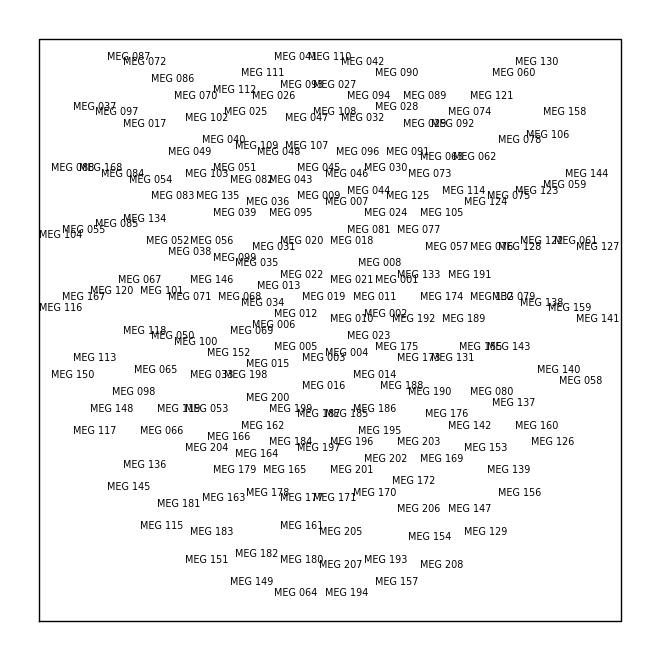

Figure(640x640)


In [5]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


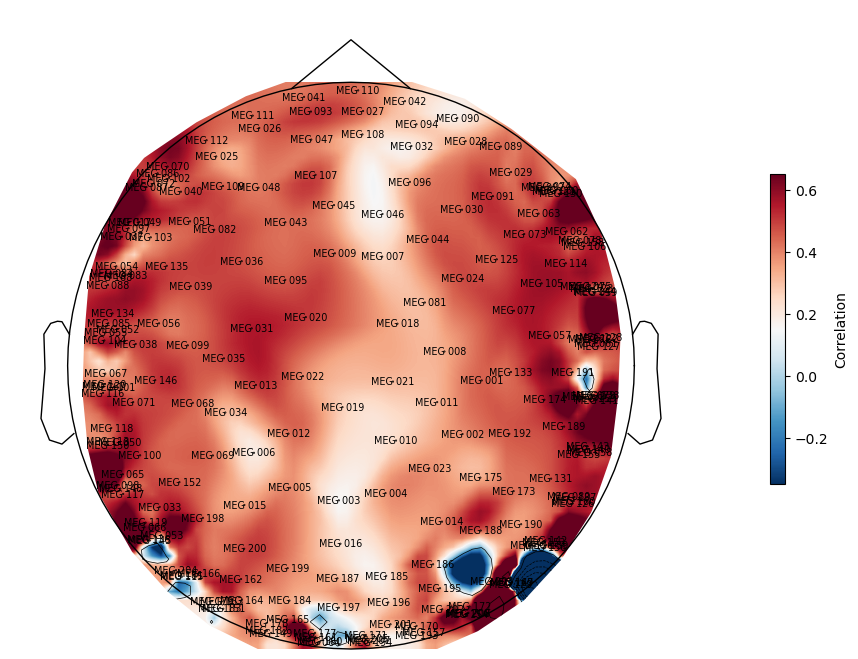

In [18]:
get_topomap(raw, correlations, (-0.35, 0.65))

In [5]:
pred_meg_y = pred_meg_y.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
print(pred_meg_y.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


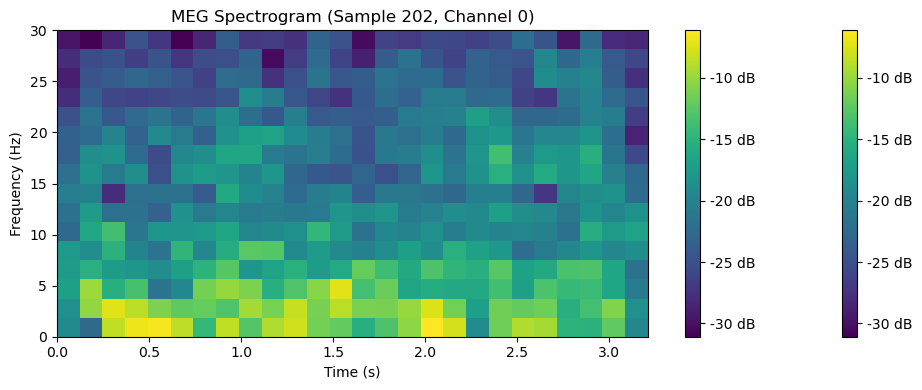

In [8]:
plot_spectrogram(pred_meg_y, sampling_meg, 202, 0)

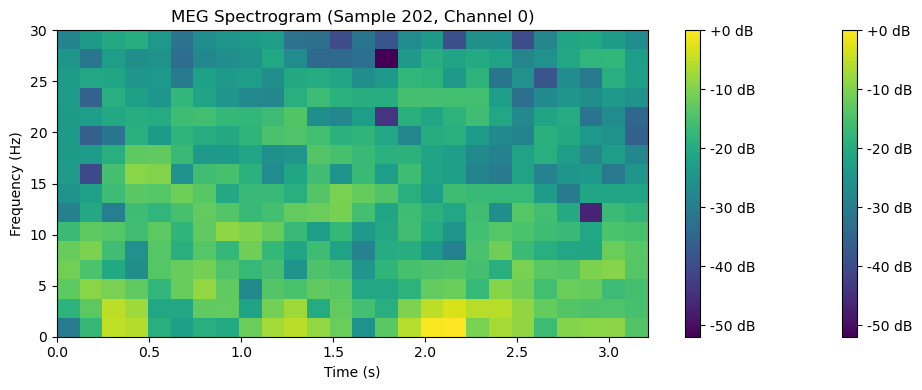

In [9]:
plot_spectrogram(real_target, sampling_meg, 202, 0)

### Estimate the cross power spectral density

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '


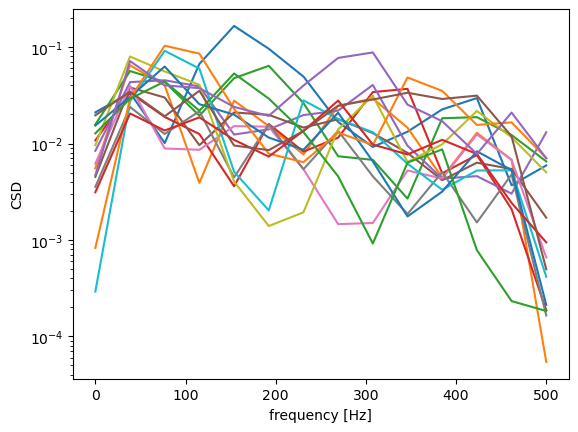

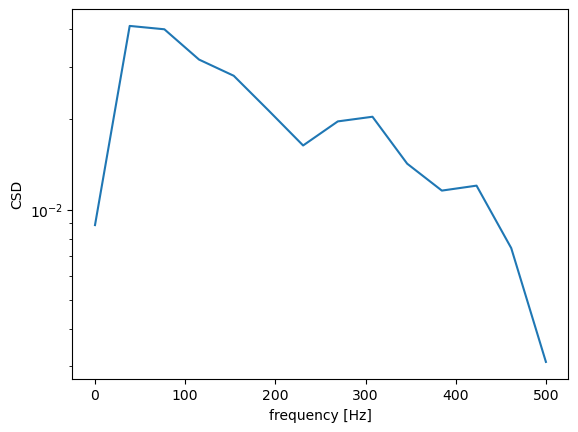

In [12]:
from scipy import signal

real_meg_202 = real_target[202, 0, :, :]
pred_meg_202 = pred_meg_y[202, 0, :, :]

assert real_meg_202.shape == pred_meg_202.shape
f, Pxy = signal.csd(real_meg_202, pred_meg_202, sampling_meg, scaling='density', average='mean')

plt.semilogy(f, np.abs(Pxy).T)
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD')
plt.show()

plt.semilogy(f, np.mean(np.abs(Pxy).T, axis=1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD')
plt.show()



## All metrics

In [10]:
# PEARSON PIXEL CORRELATION

pixel_corr = get_pixel_corr(real_target, pred_meg_y)
print("DIAG_PIX_CORRELATION_MATRIX", pixel_corr.shape)



DIAG_PIX_CORRELATION_MATRIX (208, 416)


In [7]:
real_target = real_target.reshape(real_target.shape[0], real_target.shape[1], 16, 26)
pred_meg_y = pred_meg_y.reshape(pred_meg_y.shape[0], pred_meg_y.shape[1], 16, 26)

In [8]:
# FREQUENCY BANDS METRICS

freq_bands = {
    'delta': [0, 2],
    'theta': [2, 4],
    'alpha': [4, 7],
    'beta': [7, 16],
}

metrics_by_band, corr_matrix_by_hand = bands_metrics(real_target, pred_meg_y, freq_bands)

for band_name, metrics_list in metrics_by_band.items():
    print(f'Metrics for {band_name} band:')
    for metrics in metrics_list:
        print(f"Channel {metrics['channel']}: Pearson Corr {metrics['pearson_corr']:.4f}, R^2 {metrics['r2']:.4f}, MSE {metrics['mse']:.4f}, MAE {metrics['mae']:.4f}")



Metrics for delta band:
Channel 0: Pearson Corr 0.2575, R^2 -0.1909, MSE 68.8445, MAE 6.1478
Channel 1: Pearson Corr 0.1627, R^2 -0.1907, MSE 69.0510, MAE 6.1591
Channel 2: Pearson Corr -0.3599, R^2 -0.1780, MSE 69.1766, MAE 6.1360
Channel 3: Pearson Corr 0.2796, R^2 -0.1867, MSE 68.9056, MAE 6.1709
Channel 4: Pearson Corr 0.0006, R^2 -0.1831, MSE 69.7770, MAE 6.1541
Channel 5: Pearson Corr 0.0755, R^2 -0.1863, MSE 70.1513, MAE 6.1716
Channel 6: Pearson Corr 0.0787, R^2 -0.1860, MSE 71.4787, MAE 6.3110
Channel 7: Pearson Corr -0.0253, R^2 -0.1818, MSE 69.6318, MAE 6.1704
Channel 8: Pearson Corr 0.0270, R^2 -0.1897, MSE 71.7203, MAE 6.3167
Channel 9: Pearson Corr -0.2886, R^2 -0.1892, MSE 68.9956, MAE 6.1561
Channel 10: Pearson Corr 0.1471, R^2 -0.1896, MSE 69.9232, MAE 6.1889
Channel 11: Pearson Corr 0.6080, R^2 -0.1841, MSE 69.5211, MAE 6.1770
Channel 12: Pearson Corr 0.5824, R^2 -0.1862, MSE 69.3012, MAE 6.1564
Channel 13: Pearson Corr -0.0389, R^2 -0.1861, MSE 70.2104, MAE 6.2088
Ch

In [19]:
delta_corr = corr_matrix_by_hand['delta'][0]['corr_matrix']
theta_corr = corr_matrix_by_hand['theta'][0]['corr_matrix']
alpha_corr = corr_matrix_by_hand['alpha'][0]['corr_matrix']
beta_corr = corr_matrix_by_hand['beta'][0]['corr_matrix']

print('MIN delta_corr: ',min(delta_corr))
print('MIN theta_corr: ',min(theta_corr))
print('MIN alpha_corr: ',min(alpha_corr))
print('MIN beta_corr: ',min(beta_corr))

print('MAX delta_corr: ',max(delta_corr))
print('MAX theta_corr: ',max(theta_corr))
print('MAX alpha_corr: ',max(alpha_corr))
print('MAX beta_corr: ',max(beta_corr))


MIN delta_corr:  -0.35990561692071404
MIN theta_corr:  -0.3246489444164028
MIN alpha_corr:  -0.2866931786486755
MIN beta_corr:  -0.13222481398605676
MAX delta_corr:  0.7644616620414203
MAX theta_corr:  0.4510901999383976
MAX alpha_corr:  0.4374414483147002
MAX beta_corr:  0.3808145037761875


meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


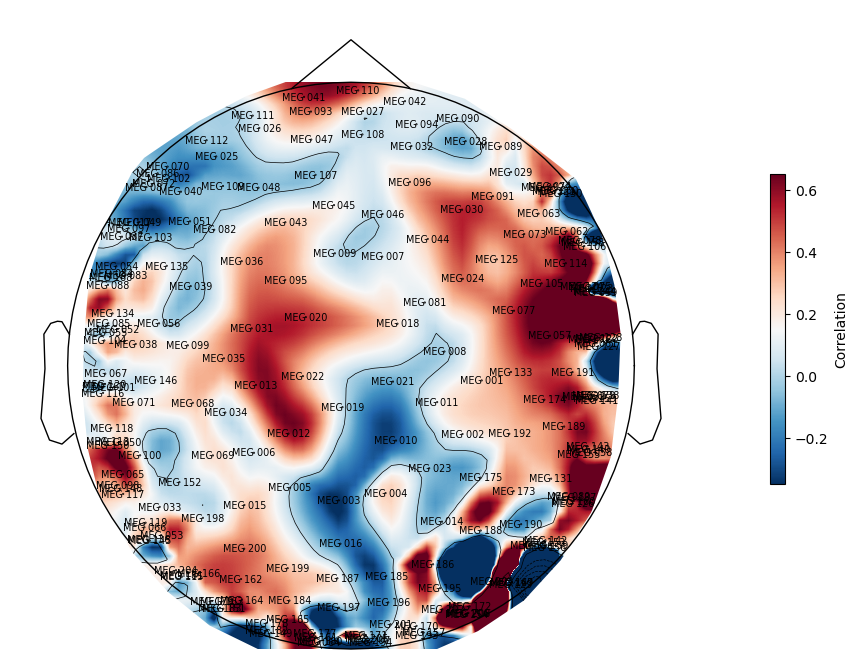

In [20]:
get_topomap(raw, delta_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


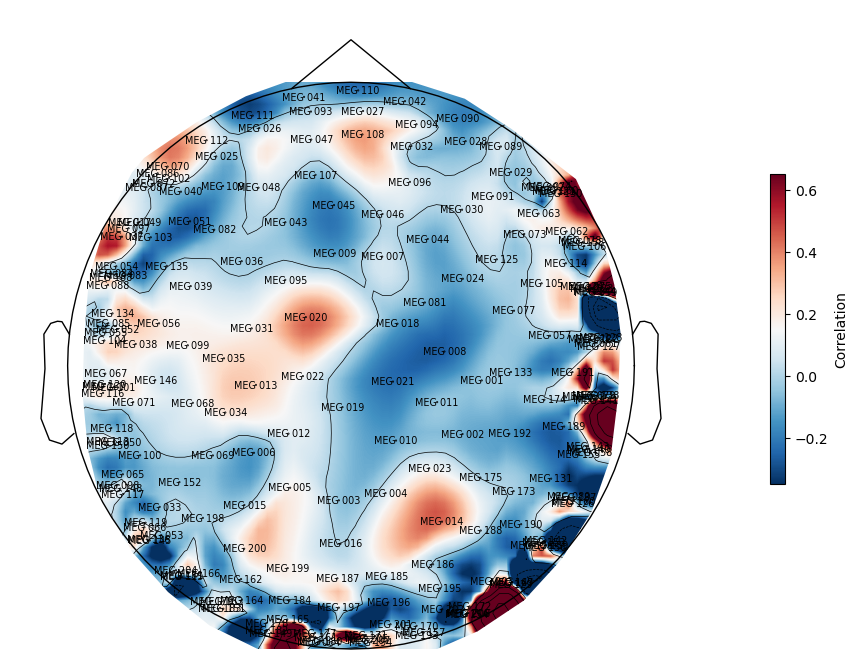

In [21]:
get_topomap(raw, theta_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


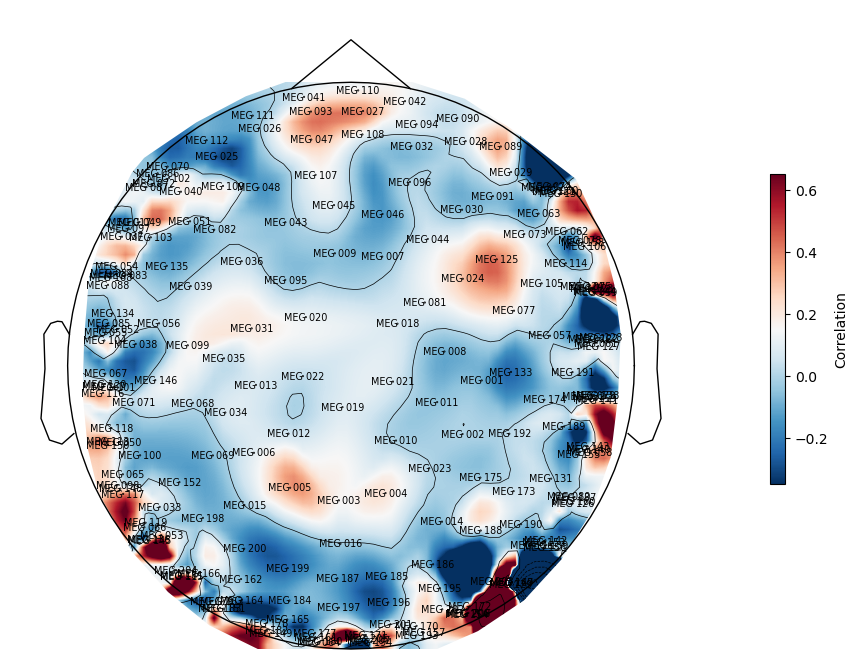

In [22]:
get_topomap(raw, alpha_corr, (-0.35, 0.65))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


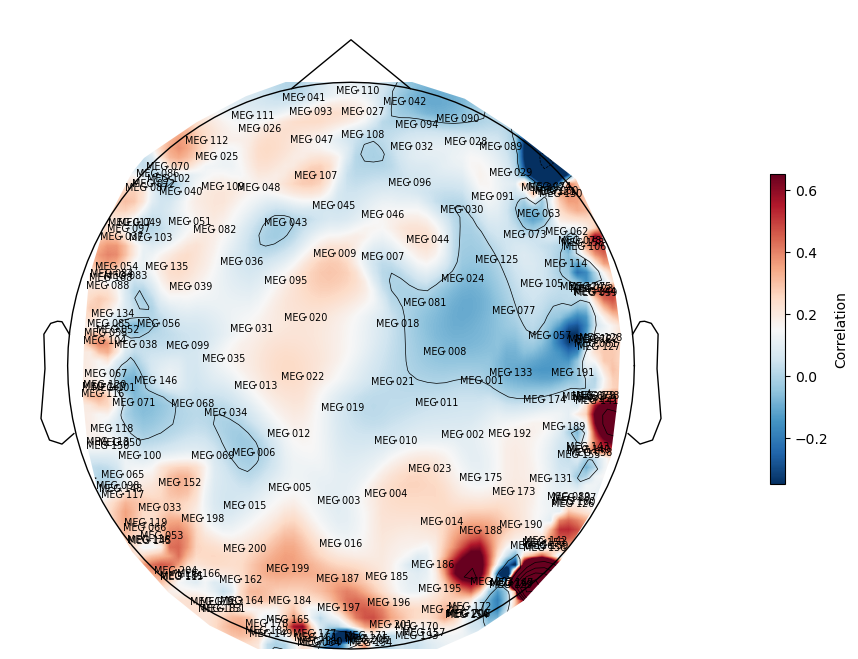

In [23]:
get_topomap(raw, beta_corr, (-0.35, 0.65))

### Kullback Divergence

In [6]:
kullback_vect = get_kullback_vect(pred_meg_y, real_target)

In [7]:
kullback_vect

array([0.11055466, 0.09595714, 0.17697813, 0.13131803, 0.10146103,
       0.11077527, 0.14608749, 0.12017305, 0.13339047, 0.15335929,
       0.1243568 , 0.13360828, 0.10842102, 0.11203271, 0.09898307,
       0.11691107, 0.18247195, 0.14092776, 0.15370362, 0.13221893,
       0.14044604, 0.11860074, 0.11188649, 0.1235572 , 0.18536832,
       0.19011357, 0.13044318, 0.14168965, 0.12162103, 0.14520228,
       0.1143561 , 0.1501833 , 0.09131085, 0.12050414, 0.10776148,
       0.15113635, 0.12822036, 0.1133526 , 0.11629663, 0.16704786,
       0.15508104, 0.15740366, 0.13245417, 0.14221084, 0.14800553,
       0.15665675, 0.14167233, 0.156217  , 0.16725681, 0.11142089,
       0.14064908, 0.1205416 , 0.09258267, 0.14891273, 0.10343631,
       0.14766519, 0.12383993, 0.06014423, 0.10332389, 0.14904327,
       0.10086672, 0.13066877, 0.12207758, 0.09127546, 0.10399862,
       0.06372657, 0.14409319, 0.10637875, 0.11636167, 0.21044758,
       0.10703253, 0.26403295, 0.15126655, 0.15305501, 0.12823

### Plotting MSE

In [50]:
delta_mse = [entry['mse'] for entry in metrics_by_band['delta']]    # ['mse']
theta_mse = [entry['mse'] for entry in metrics_by_band['theta']]
alpha_mse = [entry['mse'] for entry in metrics_by_band['alpha']]
beta_mse = [entry['mse'] for entry in metrics_by_band['beta']]

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


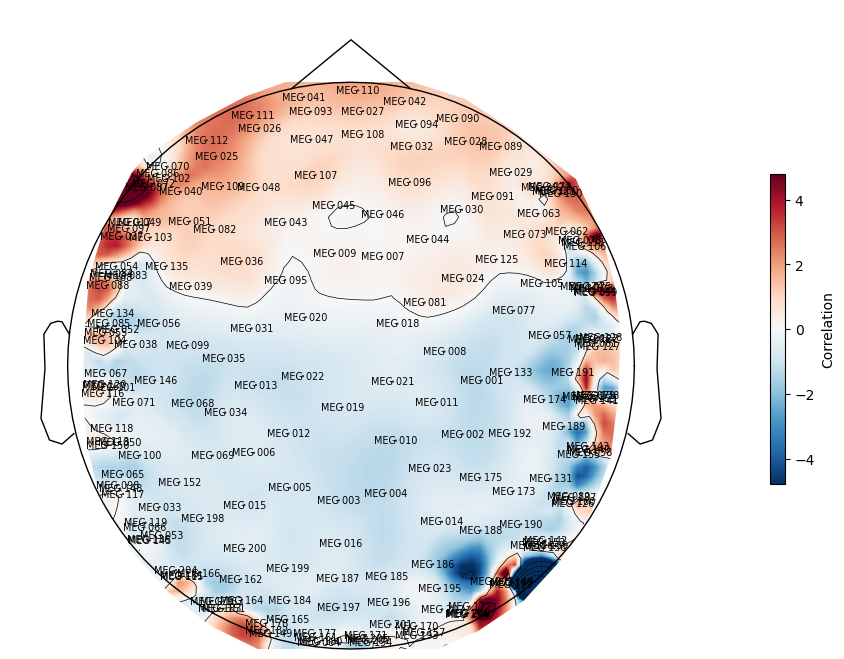

In [49]:
get_topomap(raw, delta_mse, (6.0, 6.5))